The XML file structure complies with the DAO-ML schema
All conditions are valid for the diagram /home/sowelo/Scrivania/DAO_ML_TO_SOL/DAO-ML_to_Solidity/data/CirclesDAO_v2.xml
DAO created with ID: GCDAO
DAO ID:  GCDAO
The XML file structure complies with the DAO-ML schema
All conditions are valid for the diagram /home/sowelo/Scrivania/DAO_ML_TO_SOL/DAO-ML_to_Solidity/data/CirclesDAO_v2.xml
DAO created with ID: GCDAO
DAO ID:  GCDAO
The XML file structure complies with the DAO-ML schema
All conditions are valid for the diagram /home/sowelo/Scrivania/DAO_ML_TO_SOL/DAO-ML_to_Solidity/data/CirclesDAO_v2.xml
DAO created with ID: GCDAO


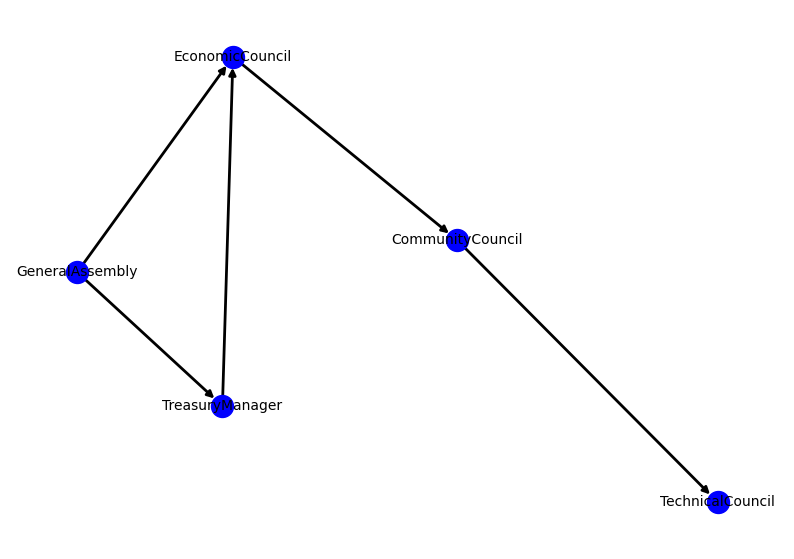

In [1]:
import json
import os
import tkinter as tk
from tkinter import messagebox, filedialog, StringVar
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import networkx as nx
import traceback
from XMLValidator import ConstraintValidator

from antlr4 import *
from XMLLexer import XMLLexer
from XMLParser import XMLParser
#from parse_xml import DAO_ML_Visitor
from DAOVisitor2 import DAOVisitor2
#from translator import ContractSourcetype
from DiagramManager import DiagramManager
from solidity_translator import SolidityTranslator

graphs = []
visitor = None


def check_and_make_folder(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    


def save_json(daos, folder_path=None):
    folder = "./out/json/daos" if folder_path is None else folder_path
    check_and_make_folder(folder)
    for dao in daos.values():
        filename = f"{folder}/dao_{dao.dao_name}.json"
        with open(filename, "w") as f:
            json.dump(dao.toJSON(), f)
    messagebox.showinfo("Success", "DAO properties have been saved to JSON files")




class TranslationData:
    def __init__(self, folder_name, contract_name, contract_translator) -> None:
        self.folder_name = folder_name
        self.contract_name = contract_name
        self.contract_translator = contract_translator

def configure_translator():
    config_window = tk.Toplevel(root)
    config_window.title("Configure Translator")
    config_window.geometry("400x350")  # Adjusted size to fit new elements
    config_window.configure(bg="#f5f5f5")

    # Logic selection label
    logic_label = tk.Label(config_window, text="Select Translation Logic:", font=("Helvetica", 12), bg="#f5f5f5")
    logic_label.pack(pady=10)

    # Radio buttons for logic selection
    simple_radio = tk.Radiobutton(config_window, text="Simple", variable=translation_logic, value="simple", font=("Helvetica", 12), bg="#f5f5f5")
    simple_radio.pack(pady=5)

    optimized_radio = tk.Radiobutton(config_window, text="Optimized", variable=translation_logic, value="optimized", font=("Helvetica", 12), bg="#f5f5f5")
    optimized_radio.pack(pady=5)

    # Checkbox for "Diamond"
    diamond_checkbox = tk.Checkbutton(config_window, text="Enable Diamond", variable=diamond_enabled, font=("Helvetica", 12), bg="#f5f5f5")
    diamond_checkbox.pack(pady=10)

    # Solidity version input
    solidity_label = tk.Label(config_window, text="Solidity Version:", font=("Helvetica", 12), bg="#f5f5f5")
    solidity_label.pack(pady=10)

    solidity_entry = tk.Entry(config_window, textvariable=solidity_version, font=("Helvetica", 12))
    solidity_entry.pack(pady=5)

    # Save button
    save_button = tk.Button(config_window, text="Save Configuration", font=("Helvetica", 12), bg="#4CAF50", fg="white", command=config_window.destroy)
    save_button.pack(pady=20)
    

def translate():
    xml_file = file_entry.get()
    if not xml_file:
        messagebox.showerror("Error", "Please enter the XML file name.")
        return None
    try:
        condition_validator = ConstraintValidator(xml_file, "data/XSD_DAO_ML.xsd")
        condition_validator.validate_dao_ml_diagram()
        input_stream = FileStream(xml_file)
        lexer = XMLLexer(input_stream)
        stream = CommonTokenStream(lexer)
        parser = XMLParser(stream)
        tree = parser.document()

        visitor = DAOVisitor2()
        diagram_manager = DiagramManager()
        visitor.parseDiagramTree(tree, diagram_manager)
        #visitor.visit(tree)
        #save_json(diagram_manager.daoByID)
        graphs.clear()
        contracts_to_write: list[TranslationData] = []
        # at first, gather all translators

        for dao_id in diagram_manager.daoByID.keys():
            print("DAO ID: ", dao_id)
            dao = diagram_manager.get_dao_by(dao_id)
            # the translator uses the selected translation logic
            if diamond_enabled.get()==True:
                translator = SolidityTranslator(dao, translation_logic.get(), diamond=True)  
            elif diamond_enabled.get()==False:
                translator = SolidityTranslator(dao, translation_logic.get(), diamond=False)
            else:
                print("error with diamond configuration: ", diamond_enabled)
            contracts_to_write.append(TranslationData(dao_id, dao_id, translator))
            # each committee is a Smart Contract by its own
            '''
            for committee in dao.committees.values():
                translator = SolidityTranslator(committee, translation_logic.get())
                contracts_to_write.append(TranslationData(dao_id, committee.committee_id, translator) )
            '''
            control_graph = dao.dao_control_graph.control_graph # visitor.get_control_graph()
            graphs.append(control_graph)

        # then, translate each Smart Contract into its translated version
        for translation_data in contracts_to_write:
            superfolder_name = "./translated/"
            folder_name = translation_data.folder_name
            name = translation_data.contract_name
            translator = translation_data.contract_translator

            folder_path = f'{superfolder_name}/{folder_name}'
            check_and_make_folder(folder_path)

            translated_smart_contracts = translator.translate()
            for tsc in translated_smart_contracts:
                if tsc is not None:
                    if tsc.folder is not None:
                        folder_path_with_subfolder = f'{folder_path}/{tsc.folder}'
                        check_and_make_folder(folder_path_with_subfolder)
                    else:
                        folder_path_with_subfolder = folder_path
                    solidity_code = tsc.get_code_as_lines()
                    if solidity_code is not None:
                        try:
                            filename = tsc.name + ".sol"
                            full_path = f'{folder_path_with_subfolder}/{filename}'

                            with open(full_path, 'w') as f:
                                for line in solidity_code:
                                    f.write(line)
                                    f.write('\n')
                                    f.flush()
                        except Exception as ex:
                            print(f"Exception while writing the source code of {name}")
                            print(ex)
                            print("the solidity code:")
                            for line in solidity_code:
                                if isinstance(line, str):
                                    print(line)
                                else:
                                    print("Error".join(line))
                
        dao_ids = ", ".join(td.contract_name for td in contracts_to_write) + ".sol"

        if graphs:
            display_button.configure(bg="green")
        else:
            display_button.configure(bg="gray")
        messagebox.showinfo("Success", f"Translation completed successfully! {dao_ids} created.")

    except Exception as e:
        traceback.print_exception(e)
        messagebox.showerror("Error", f"An error occurred: {e}")
        print("Error", f"An error occurred: {e}")


def browse_file():
    file_path = filedialog.askopenfilename(filetypes=[("XML files", "*.xml")])
    file_entry.delete(0, tk.END)
    file_entry.insert(0, file_path)


def display_control_graph():
    #print("CONTROL GRAPH at the beginning of display control graphs", graphs)
    if not graphs:
        messagebox.showinfo("Info", "No control graph to display.")
        return

    graph_window = tk.Toplevel(root)
    graph_window.title("Control Graph")
    graph_window.geometry("1000x700")

    fig, ax = plt.subplots(figsize=(20, 20))
    
    for graph in graphs:
        pos = nx.spring_layout(graph, seed=42)

        # sccs = list(nx.strongly_connected_components(graph))  # SCCs as list of sets
        
        # scc_edges = []
        # for scc in sccs:
        #     subgraph = graph.subgraph(scc)
        #     scc_edges.extend(subgraph.edges())
        # for edge in scc_edges:
        #     print("SCC Edges: ", edge)
        
        # self_loops = list(nx.nodes_with_selfloops(graph))
        #node_colors = [graph.nodes[node]['color'] for node in graph.nodes()]
        
        nx.draw(graph, 
                pos, 
                with_labels=True, 
                node_color="blue", 
                node_size=250,  
                ax=ax, 
                font_size=10,  
                edge_color="black",
                linewidths=1, 
                width=2)
        # nx.draw_networkx_edges(graph, pos, edgelist=scc_edges, edge_color='orange', width=3)
        
        # nx.draw_networkx_edges(graph, pos, edgelist=self_loops, edge_color='red', width=4)

    canvas = FigureCanvasTkAgg(fig, master=graph_window)
    canvas.draw()
    canvas.get_tk_widget().pack()


# def print_object_properties():
#     global visitor
#     if not visitor:
#         print("No object properties to display.")
#         return

#     i = 0
#     for dao in visitor.daos.values():F
#         filename = "dao_properties_" + str(i) + ".txt"
#         with open(filename, "w") as file:
#             file.write(f"\n--- DAO {i + 1} ---\n")
#             file.write(str(dao))
#         i += 1
    
#     messagebox.showinfo("Success", "DAO properties have been saved to dao_properties.txt")


def print_json():
    folder = "./out/json"
    check_and_make_folder(folder)
    xml_file = file_entry.get()

    if not xml_file:
        messagebox.showerror("Error", "Please enter the XML file name.")
        return None

    try:
        condition_validator = ConstraintValidator(xml_file, "data/XSD_DAO_ML.xsd")
        condition_validator.validate_dao_ml_diagram()
        input_stream = FileStream(xml_file)
        lexer = XMLLexer(input_stream)
        stream = CommonTokenStream(lexer)
        parser = XMLParser(stream)
        tree = parser.document()
        visitor = DAOVisitor2()
        diagram_manager = DiagramManager()        
        visitor.parseDiagramTree(tree, diagram_manager)
        #visitor.visit(tree)
        save_json(diagram_manager.daoByID)
        #messagebox.showinfo("Success", "DAO properties have been saved to JSON files")
    except Exception as e:
        traceback.print_exception(e)
        messagebox.showerror("Error", f"An error occurred: {e}")
    

root = tk.Tk()
root.title("DAO-ML to Solidity Translator")
root.geometry("1200x1000")
root.configure(bg="#f5f5f5")

# Default to "simple" logic
translation_logic = StringVar(value="simple")  
diamond_enabled = tk.BooleanVar(value=False)  # Define this at the global level outside the function
#diamond_enabled.set(False) 

solidity_version = tk.StringVar(value="^0.8.0")  # Similarly, initialize this here
    
    
title_label = tk.Label(root, text="DAO-ML to Solidity Translator", font=("Helvetica", 16, "bold"), bg="#f5f5f5", fg="#333")
title_label.pack(pady=10)

frame = tk.Frame(root, bg="#f5f5f5")
frame.pack(pady=10)

file_label = tk.Label(frame, text="XML File:", font=("Helvetica", 12), bg="#f5f5f5", fg="#333")
file_label.pack(side=tk.LEFT, padx=5)

file_entry = tk.Entry(frame, width=40, font=("Helvetica", 12))
file_entry.pack(side=tk.LEFT, padx=5)

browse_button = tk.Button(frame, text="Browse", font=("Helvetica", 12), command=browse_file)
browse_button.pack(side=tk.LEFT, padx=5)

translate_button = tk.Button(root, text="Translate DAO-ML Model to Solidity", font=("Helvetica", 14), bg="#4CAF50", fg="white", command=translate)
translate_button.pack(pady=20)

config_button = tk.Button(root, text="Configure Translator", font=("Helvetica", 14), bg="#FF9800", fg="white", command=configure_translator)
config_button.pack(pady=20)

display_button = tk.Button(root, text="Display Control Graph", font=("Helvetica", 14), bg="gray", fg="white", command=display_control_graph)
display_button.pack(pady=20)

# print_button = tk.Button(root, text="Print Object Properties", font=("Helvetica", 14), bg="#4CAF50", fg="white", command=print_object_properties)
# print_button.pack(pady=20)

print_button = tk.Button(root, text="Print to JSON", font=("Helvetica", 14), bg="#4CAF50", fg="white", command=print_json)
print_button.pack(pady=20)

root.mainloop()
